# ============================================================
# Computational QSAR Analysis of Bioactive Antimalarial Constituents from Newbouldia laevis
#  Author: Favour Ogadinma Izuagba
#  Affiliation: Chemsolvers Research and Computational Laboratories
#  Federal University of Technology, Owerri, Imo state, Nigeria.
# ============================================================

### Short Note: Library Imports for QSAR Classification

- **pandas, numpy:** Data manipulation and numerical operations.  
- **RDKit (Chem, AllChem):** Molecular structure handling and fingerprint generation.  
- **scikit-learn:**  
  - `train_test_split` for dataset splitting.  
  - `SelectKBest`, `mutual_info_classif` for feature selection.  
  - `RandomForestClassifier` for model building.  
  - Metrics (`roc_auc_score`, `accuracy_score`, etc.) for evaluation.  
- **matplotlib, seaborn:** Visualization of results (plots, heatmaps, ROC curves).  


In [80]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [81]:
# Read dataset
df = pd.read_csv("D:\Github_project\QSAR-Antimalarial-Model\data\chembl_malaria_inhibitors.csv")

# Display first 5 rows
print(df.head())

# Check for missing values
print(df.isnull().sum())

  Molecule ChEMBL ID                                             Smiles  \
0       CHEMBL444605              CC(=O)OCCCc1nc(N)nc(N)c1-c1cccc(Cl)c1   
1        CHEMBL21395               CCOc1cc(Cc2cnc(N)nc2N)ccc1OCc1ccccc1   
2       CHEMBL291931                COc1ccc(Cc2cnc(N)nc2N)cc1OCc1ccccc1   
3       CHEMBL274031                Nc1ncc(Cc2cccc(OCc3ccccc3)c2)c(N)n1   
4        CHEMBL22139  CCCOc1cc(Cc2cnc(N)nc2N)ccc1OCc1cc(OC)c(OC)c(OC)c1   

   pChEMBL Value  
0           5.28  
1           6.92  
2           5.24  
3           4.89  
4           7.52  
Molecule ChEMBL ID    0
Smiles                0
pChEMBL Value         0
dtype: int64


In [82]:
# Check for missing values
print(df.isnull().sum())

Molecule ChEMBL ID    0
Smiles                0
pChEMBL Value         0
dtype: int64


In [83]:
 #Dataset dimensions
print("Shape of dataset:", df.shape, "\n")

Shape of dataset: (340, 3) 



###  Short Note: Activity Classification Function

- Defines a simple **binary classification function** for activity.  
- Returns `1` (strong_inhibitors) if the input `value >= 6.5`.  
- Returns `0` (weak_inhibitors) if the input `value < 6.5`.  
- Useful for **converting continuous pIC50 values into classes** for classification models.

In [84]:
def activity(value):
  if value >= 6.5:
    return 1
  else:
    return 0

In [86]:
 df['activity'] = df['pChEMBL Value'].apply(activity)

In [87]:
df

,Molecule ChEMBL ID,Smiles,pChEMBL Value,activity
0,CHEMBL444605,CC(=O)OCCCc1nc(N)nc(N)c1-c1cccc(Cl)c1,5.28,0
1,CHEMBL21395,CCOc1cc(Cc2cnc(N)nc2N)ccc1OCc1ccccc1,6.92,1
2,CHEMBL291931,COc1ccc(Cc2cnc(N)nc2N)cc1OCc1ccccc1,5.24,0
3,CHEMBL274031,Nc1ncc(Cc2cccc(OCc3ccccc3)c2)c(N)n1,4.89,0
4,CHEMBL22139,CCCOc1cc(Cc2cnc(N)nc2N)ccc1OCc1cc(OC)c(OC)c(OC)c1,7.52,1
...,...,...,...,...
335,CHEMBL747,CC1(C)N=C(N)N=C(N)N1c1ccc(Cl)cc1,7.40,1
336,CHEMBL5822647,CCCc1nc(N)nc(N)c1N1CCN(c2ccccc2)CC1,7.85,1
337,CHEMBL34259,CN(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)N[C@@H](CC...,9.05,1
338,CHEMBL36,CCc1nc(N)nc(N)c1-c1ccc(Cl)cc1,8.28,1


In [88]:
# Count how many are active (activity = 1) and inactive (activity = 0)
activity_counts = df['activity'].value_counts()
activity_counts

activity
0    229
1    111
Name: count, dtype: int64


This script converts SMILES strings into numerical molecular fingerprints for QSAR or machine learning.

- **Step 1:** Imports RDKit, NumPy, and pandas libraries.  
- **Step 2:** Converts SMILES strings to valid RDKit molecule objects.  
- **Step 3:** Calculates either **ECFP (Morgan)** or **Avalon** fingerprints.  
- **Step 4:** Transforms fingerprints into numerical arrays.  
- **Step 5:** Combines fingerprint data with the original DataFrame for modeling.

**Output:**  
A single DataFrame containing molecular information and corresponding fingerprint features.


In [89]:
# Step 1 — Importing Libraries
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Avalon import pyAvalonTools
import numpy as np
import pandas as pd
# Step 2 — Converting SMILES to Molecules
def smiles_to_mols(smiles_list):
    mols = []
    valid_idx = []
    for i, smi in enumerate(smiles_list):
        mol = Chem.MolFromSmiles(smi)
        if mol:
            mols.append(mol)
            valid_idx.append(i)
    return mols, valid_idx
# Step 3 — Calculating Fingerprints
def calculate_fingerprints(df, smiles_col='Smiles', method='ecfp', radius=2, nBits=1024):
    """
    Calculates ECFP or Avalon fingerprints and returns a merged DataFrame.

    Parameters:
        df (pd.DataFrame): Input DataFrame with a column of SMILES strings.
        smiles_col (str): Name of the SMILES column.
        method (str): 'ecfp' or 'avalon'.
        radius (int): Radius for ECFP (ignored for Avalon).
        nBits (int): Number of bits for the fingerprint.

    Returns:
        pd.DataFrame: Original DataFrame concatenated with fingerprint bits.
    """
    # Step 4 — Generating the Fingerprints
    smiles_list = df[smiles_col]
    mols, valid_idx = smiles_to_mols(smiles_list)
    fingerprints = []

    for mol in mols:
        if method == 'ecfp':
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits)
        elif method == 'avalon':
            fp = pyAvalonTools.GetAvalonFP(mol, nBits=nBits)
        else:
            raise ValueError("Method must be 'ecfp' or 'avalon'")
        # Step 5 — Converting Fingerprints to Numbers
        fp_np = np.zeros((nBits,), dtype=int)
        DataStructs.ConvertToNumpyArray(fp, fp_np)
        fingerprints.append(fp_np)

    # Create DataFrame for fingerprints
    prefix = method.upper()
    fp_df = pd.DataFrame(fingerprints, columns=[f'{prefix}_{i}' for i in range(nBits)])
    fp_df.index = valid_idx

    # Keep only valid molecules
    df_valid = df.iloc[valid_idx].reset_index(drop=True)
    fp_df = fp_df.reset_index(drop=True)

    # Concatenate and return
    return pd.concat([df_valid, fp_df], axis=1)

In [90]:
df_with_ecfp = calculate_fingerprints(df, smiles_col='Smiles', method='ecfp', radius=2, nBits=1024)

[10:38:07] DEPRECATION WARNING: please use MorganGenerator
[10:38:07] DEPRECATION WARNING: please use MorganGenerator
[10:38:07] DEPRECATION WARNING: please use MorganGenerator
[10:38:07] DEPRECATION WARNING: please use MorganGenerator
[10:38:07] DEPRECATION WARNING: please use MorganGenerator
[10:38:07] DEPRECATION WARNING: please use MorganGenerator
[10:38:07] DEPRECATION WARNING: please use MorganGenerator
[10:38:07] DEPRECATION WARNING: please use MorganGenerator
[10:38:07] DEPRECATION WARNING: please use MorganGenerator
[10:38:07] DEPRECATION WARNING: please use MorganGenerator
[10:38:07] DEPRECATION WARNING: please use MorganGenerator
[10:38:07] DEPRECATION WARNING: please use MorganGenerator
[10:38:07] DEPRECATION WARNING: please use MorganGenerator
[10:38:07] DEPRECATION WARNING: please use MorganGenerator
[10:38:07] DEPRECATION WARNING: please use MorganGenerator
[10:38:07] DEPRECATION WARNING: please use MorganGenerator
[10:38:07] DEPRECATION WARNING: please use MorganGenerat

In [91]:
df_with_ecfp

,Molecule ChEMBL ID,Smiles,pChEMBL Value,activity,ECFP_0,ECFP_1,ECFP_2,ECFP_3,ECFP_4,ECFP_5,...,ECFP_1014,ECFP_1015,ECFP_1016,ECFP_1017,ECFP_1018,ECFP_1019,ECFP_1020,ECFP_1021,ECFP_1022,ECFP_1023
0,CHEMBL444605,CC(=O)OCCCc1nc(N)nc(N)c1-c1cccc(Cl)c1,5.28,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,CHEMBL21395,CCOc1cc(Cc2cnc(N)nc2N)ccc1OCc1ccccc1,6.92,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
2,CHEMBL291931,COc1ccc(Cc2cnc(N)nc2N)cc1OCc1ccccc1,5.24,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
3,CHEMBL274031,Nc1ncc(Cc2cccc(OCc3ccccc3)c2)c(N)n1,4.89,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,CHEMBL22139,CCCOc1cc(Cc2cnc(N)nc2N)ccc1OCc1cc(OC)c(OC)c(OC)c1,7.52,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,CHEMBL747,CC1(C)N=C(N)N=C(N)N1c1ccc(Cl)cc1,7.40,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
336,CHEMBL5822647,CCCc1nc(N)nc(N)c1N1CCN(c2ccccc2)CC1,7.85,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
337,CHEMBL34259,CN(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)N[C@@H](CC...,9.05,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
338,CHEMBL36,CCc1nc(N)nc(N)c1-c1ccc(Cl)cc1,8.28,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [92]:
X = df_with_ecfp.drop(columns=['Smiles', 'Molecule ChEMBL ID','pChEMBL Value','activity'])

In [93]:
X

,ECFP_0,ECFP_1,ECFP_2,ECFP_3,ECFP_4,ECFP_5,ECFP_6,ECFP_7,ECFP_8,ECFP_9,...,ECFP_1014,ECFP_1015,ECFP_1016,ECFP_1017,ECFP_1018,ECFP_1019,ECFP_1020,ECFP_1021,ECFP_1022,ECFP_1023
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
336,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
337,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
338,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [94]:
y = df_with_ecfp['activity']

In [95]:
y

0      0
1      1
2      0
3      0
4      1
      ..
335    1
336    1
337    1
338    1
339    1
Name: activity, Length: 340, dtype: int64

In [96]:
print(type(y))
print(y.shape)


<class 'pandas.core.series.Series'>
(340,)


In [97]:
print(X.shape, y.shape)


(340, 1024) (340,)


In [98]:
# Step 1: Remove constant features
X = X.loc[:, X.nunique() > 1]

In [99]:
X

,ECFP_1,ECFP_2,ECFP_3,ECFP_4,ECFP_6,ECFP_7,ECFP_8,ECFP_10,ECFP_11,ECFP_13,...,ECFP_989,ECFP_993,ECFP_997,ECFP_1002,ECFP_1008,ECFP_1010,ECFP_1011,ECFP_1017,ECFP_1018,ECFP_1019
0,0,0,0,0,0,0,0,0,1,1,...,0,0,1,0,0,0,0,1,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
336,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
337,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
338,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Train-Test Split and CSV Export

- Converts **features (`X`)** to a DataFrame and **target (`y`)** to a Series.  
- Splits dataset into **80% training** and **20% testing** using stratification to preserve class balance.  
- Creates an **output folder** to store dataset splits.  
- Saves **X_train, X_test, y_train, y_test** as CSV files for reproducibility.  
- Prints the **shapes of the splits** to confirm correct partitioning.


In [100]:
from sklearn.model_selection import train_test_split
import pandas as pd
import os

# Ensure X is a DataFrame and y is a Series
X = pd.DataFrame(X)
y = pd.Series(y)

# ---------------- Split 80% train, 20% test ----------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ---------------- Output folder ----------------
output_dir = r"D:\Github_project\QSAR-Antimalarial-Model\data\.gitkeep\malaria_dataset_splits"
os.makedirs(output_dir, exist_ok=True)

# ---------------- Save splits to CSV ----------------
X_train.to_csv(os.path.join(output_dir, "X_train.csv"), index=False)
y_train.to_csv(os.path.join(output_dir, "y_train.csv"), index=False)
X_test.to_csv(os.path.join(output_dir, "X_test.csv"), index=False)
y_test.to_csv(os.path.join(output_dir, "y_test.csv"), index=False)

# ---------------- Print dataset shapes ----------------
print("Dataset split complete!")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


Dataset split complete!
X_train shape: (272, 407), y_train shape: (272,)
X_test shape: (68, 407), y_test shape: (68,)


In [104]:
X_train

,ECFP_1,ECFP_2,ECFP_3,ECFP_4,ECFP_6,ECFP_7,ECFP_8,ECFP_10,ECFP_11,ECFP_13,...,ECFP_989,ECFP_993,ECFP_997,ECFP_1002,ECFP_1008,ECFP_1010,ECFP_1011,ECFP_1017,ECFP_1018,ECFP_1019
86,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
95,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
131,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
142,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
50,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
26,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
169,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
119,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [105]:
y_train

86     0
95     1
131    0
142    0
50     0
      ..
252    0
26     0
169    0
119    0
71     1
Name: activity, Length: 272, dtype: int64

# **Synthetic Minority Over-Sampling Technique**


This code addresses **class imbalance** in a classification dataset using **SMOTE (Synthetic Minority Over-sampling Technique)**:




In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

counter = Counter(y_train)
print('Before', counter)

# oversampling the train dataset using SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

counter = Counter(y_train_res)
print('After', counter)

Before Counter({0: 183, 1: 89})
After Counter({0: 183, 1: 183})


In [107]:
counter = Counter(X_train.shape)
print('Before', counter)

Before Counter({272: 1, 407: 1})


In [108]:
counter = Counter(X_train_res.shape)
print('After', counter)

After Counter({366: 1, 407: 1})


In [109]:
X_train_res.shape

(366, 407)

In [110]:
X_test.shape

(68, 407)

# **Feature Selection**


This code selects the most relevant features for classification using **mutual information**:

In [111]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Mutual information with fixed random_state for reproducibility
selector = SelectKBest(score_func=lambda X, y: mutual_info_classif(X, y, random_state=42), k=100)

# Fit on oversampled training data
X_train_selected = selector.fit_transform(X_train_res, y_train_res)

# Apply same selection to validation/test (no SMOTE here!)
X_test_selected = selector.transform(X_test)

print("Selected features shape:", X_train_selected.shape)


Selected features shape: (366, 100)


In [112]:

# Get the selected feature names
selected_features = X_train.columns[selector.get_support()]

#  Make a dataframe with scores
feature_scores = pd.DataFrame({
    'Features': selected_features,
    'Scores': selector.scores_[selector.get_support()]
}).sort_values(by='Scores', ascending=False)

print(feature_scores.head(15))

    Features    Scores
37  ECFP_334  0.088068
65  ECFP_638  0.082510
97  ECFP_980  0.073901
27  ECFP_233  0.072944
8    ECFP_78  0.072136
71  ECFP_667  0.071116
9   ECFP_127  0.068978
39  ECFP_346  0.067452
63  ECFP_622  0.067225
73  ECFP_677  0.064715
70  ECFP_661  0.062315
55  ECFP_530  0.059361
25  ECFP_214  0.057678
82  ECFP_738  0.057221
21  ECFP_203  0.057155


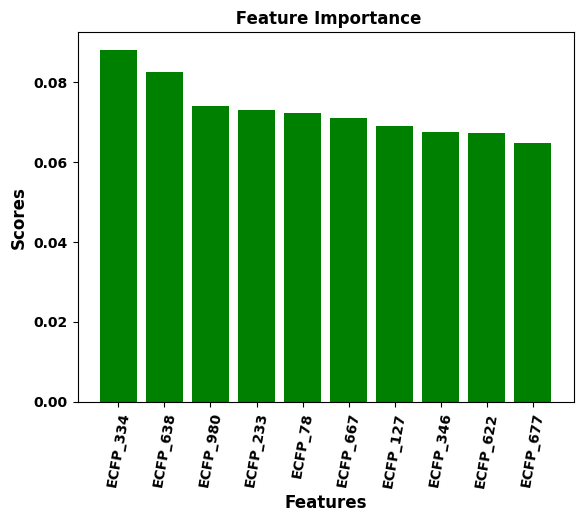

<Figure size 1000x1000 with 0 Axes>

In [113]:
import matplotlib.pyplot as plt

top_features = feature_scores.head(10)

plt.bar(top_features['Features'], top_features['Scores'], color='green')
plt.title(" Feature Importance", fontweight='bold')
plt.xlabel("Features", fontsize=12, fontweight='bold')
plt.ylabel("Scores", fontsize=12, fontweight='bold')
plt.xticks(rotation=80, fontweight="bold")
plt.yticks(fontweight="bold")
# plt.tight_layout()
fig = plt.figure(figsize=(10,10))
plt.savefig("Top1o_Features.jpg", dpi=300)
plt.show()

# **Hyperparameter**

- Trains a **Logistic Regression** classifier on **SMOTE-balanced training data**.  
- Uses **GridSearchCV** to find optimal hyperparameters.  
- Applies **stratified 5-fold cross-validation** for robust evaluation.  
- Outputs predictions and probabilities for **train and test sets**.  
- Optimizes for **balanced accuracy** to handle class imbalance.


In [114]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score,
    balanced_accuracy_score, matthews_corrcoef, roc_curve,
    precision_recall_curve
)
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt


# --------------------------
# 3. GridSearchCV Logistic Regression
# --------------------------
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

log_reg = LogisticRegression(max_iter=5000, random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring='balanced_accuracy',
    cv=cv,
    n_jobs=-1
)

grid.fit(X_train_selected, y_train_res)

print("Best Parameters:", grid.best_params_)
print("Best CV Balanced Accuracy:", grid.best_score_)

# --------------------------
# 4. Evaluate Best Model
# --------------------------
best_model = grid.best_estimator_

# Predictions
y_train_pred = best_model.predict(X_train_selected)
y_test_pred = best_model.predict(X_test_selected)

y_train_prob = best_model.predict_proba(X_train_selected)[:, 1]
y_test_prob = best_model.predict_proba(X_test_selected)[:, 1]

Best Parameters: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best CV Balanced Accuracy: 0.7324324324324325


### Classification Model Evaluation

- Generates **predictions and probabilities** for train/test sets.  
- Computes **accuracy, precision, recall, F1, MCC, specificity, balanced accuracy**.  
- Displays **confusion matrices** and **classification reports**.  
- Plots **ROC curve (AUC)** and **Precision-Recall curve (AP)**.  
- Provides a **comprehensive performance overview** for imbalanced datasets.



Train Accuracy: 0.7978
Test Accuracy: 0.6912
Train Precision: 0.8060
Test Precision: 0.6373
Train Recall: 0.7978
Test Recall: 0.6176
Train F1-score: 0.7964
Test F1-score: 0.6225
Matthews correlation coefficient (Train): 0.6038
Matthews correlation coefficient (Test): 0.2541
Train Specificity: 0.8798
Test Specificity: 0.8261
Train Balanced Accuracy: 0.7978
Test Balanced Accuracy: 0.6176

Classification Report (Train):
              precision    recall  f1-score   support

           0       0.76      0.88      0.81       183
           1       0.86      0.72      0.78       183

    accuracy                           0.80       366
   macro avg       0.81      0.80      0.80       366
weighted avg       0.81      0.80      0.80       366


Classification Report (Test):
              precision    recall  f1-score   support

           0       0.75      0.83      0.78        46
           1       0.53      0.41      0.46        22

    accuracy                           0.69        68
   

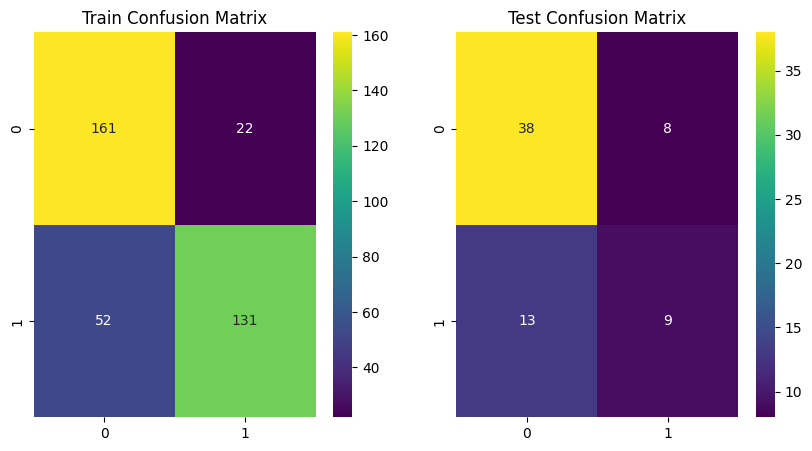

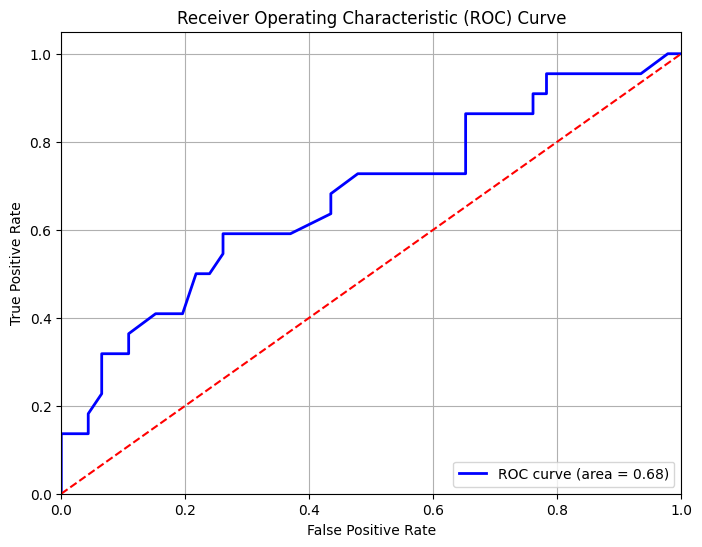

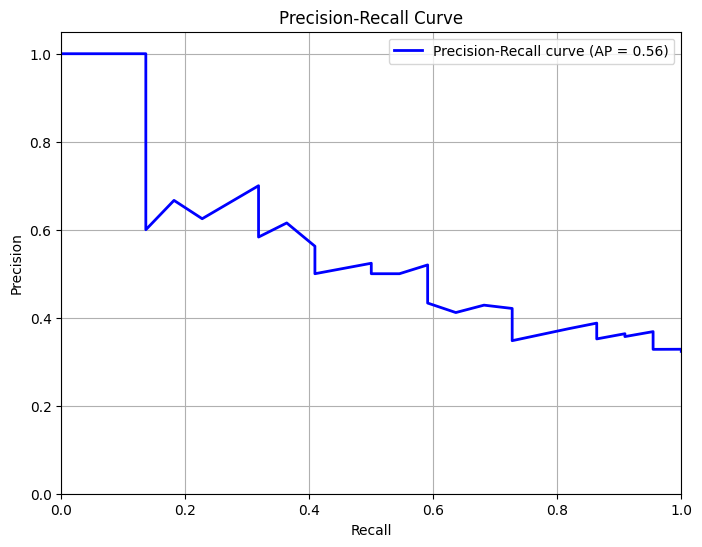

In [116]:
import numpy as np
import pandas as pd
from sklearn import metrics

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    matthews_corrcoef, classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve, average_precision_score
)

from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.metrics import confusion_matrix

# --------------------------
# 4. Evaluate Best Model
# --------------------------
best_model = grid.best_estimator_

# Predictions
pred_train = best_model.predict(X_train_selected)
pred_test = best_model.predict(X_test_selected)

pred_train_prob = best_model.predict_proba(X_train_selected)[:, 1]
pred_test_prob = best_model.predict_proba(X_test_selected)[:, 1]



# Initialize lists to store scores
metrics_dict = {
    'train_acc': [], 'test_acc': [],
    'train_prec': [], 'test_prec': [],
    'train_recall': [], 'test_recall': [],
    'train_f1': [], 'test_f1': [],
    'train_mcc': [], 'test_mcc': [],
    'train_spec': [], 'test_spec': [],
    'train_bal_acc': [], 'test_bal_acc': []
}

final_train_conf_matrix, final_test_conf_matrix = None, None

# 5. Calculate performance metrics
metrics_dict['train_acc'].append(metrics.accuracy_score(y_train_res, pred_train))
metrics_dict['test_acc'].append(metrics.accuracy_score(y_test, pred_test))

metrics_dict['train_prec'].append(metrics.precision_score(y_train_res, pred_train, average="macro"))
metrics_dict['test_prec'].append(metrics.precision_score(y_test, pred_test, average="macro"))

metrics_dict['train_recall'].append(metrics.recall_score(y_train_res, pred_train, average="macro"))
metrics_dict['test_recall'].append(metrics.recall_score(y_test, pred_test, average="macro"))

metrics_dict['train_f1'].append(metrics.f1_score(y_train_res, pred_train, average="macro"))
metrics_dict['test_f1'].append(metrics.f1_score(y_test, pred_test, average="macro"))

metrics_dict['train_mcc'].append(metrics.matthews_corrcoef(y_train_res, pred_train))
metrics_dict['test_mcc'].append(metrics.matthews_corrcoef(y_test, pred_test))

metrics_dict['train_bal_acc'].append(balanced_accuracy_score(y_train_res, pred_train))
metrics_dict['test_bal_acc'].append(balanced_accuracy_score(y_test, pred_test))


# -------- Calculate specificity --------
def calc_specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0,0]
    fp = cm[0,1]
    specificity = tn / (tn + fp)
    return specificity

metrics_dict['train_spec'].append(calc_specificity(y_train_res, pred_train))
metrics_dict['test_spec'].append(calc_specificity(y_test, pred_test))

# # Store confusion matrices from the last fold
# if fold_idx == (cv.n_splits - 1):
#     final_train_conf_matrix = confusion_matrix(y_train, pred_train)
#     final_test_conf_matrix = confusion_matrix(y_test, pred_test)

# Store confusion matrices for this split
final_train_conf_matrix = confusion_matrix(y_train_res, pred_train)

final_test_conf_matrix = confusion_matrix(y_test, pred_test)


# 6. Print average performance metrics across all folds
print(f"Train Accuracy: {np.mean(metrics_dict['train_acc']):.4f}")
print(f"Test Accuracy: {np.mean(metrics_dict['test_acc']):.4f}")
print(f"Train Precision: {np.mean(metrics_dict['train_prec']):.4f}")
print(f"Test Precision: {np.mean(metrics_dict['test_prec']):.4f}")
print(f"Train Recall: {np.mean(metrics_dict['train_recall']):.4f}")
print(f"Test Recall: {np.mean(metrics_dict['test_recall']):.4f}")
print(f"Train F1-score: {np.mean(metrics_dict['train_f1']):.4f}")
print(f"Test F1-score: {np.mean(metrics_dict['test_f1']):.4f}")
print(f"Matthews correlation coefficient (Train): {np.mean(metrics_dict['train_mcc']):.4f}")
print(f"Matthews correlation coefficient (Test): {np.mean(metrics_dict['test_mcc']):.4f}")
print(f"Train Specificity: {np.mean(metrics_dict['train_spec']):.4f}")
print(f"Test Specificity: {np.mean(metrics_dict['test_spec']):.4f}")
print(f"Train Balanced Accuracy: {np.mean(metrics_dict['train_bal_acc']):.4f}")
print(f"Test Balanced Accuracy: {np.mean(metrics_dict['test_bal_acc']):.4f}")


# 7. Classification reports for the final fold
print("\nClassification Report (Train):")
print(metrics.classification_report(y_train_res, pred_train))

print("\nClassification Report (Test):")
print(metrics.classification_report(y_test, pred_test))

# 8. Plot Confusion Matrix for the final fold
plt.figure(figsize=(10, 5))

# Confusion matrix for Train data
plt.subplot(1, 2, 1)
sns.heatmap(final_train_conf_matrix, annot=True, cmap='viridis', fmt="g")
plt.title('Train Confusion Matrix')

# Confusion matrix for Test data
plt.subplot(1, 2, 2)
sns.heatmap(final_test_conf_matrix, annot=True, cmap='viridis', fmt="g")
plt.title('Test Confusion Matrix')

plt.show()


# 9. Compute ROC Curve and AUC
pred_test_prob = best_model.predict_proba(X_test_selected)[:, 1]
fpr, tpr, _ = roc_curve(y_test, pred_test_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

precision, recall, _ = precision_recall_curve(y_test, pred_test_prob)
average_precision = average_precision_score(y_test, pred_test_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (AP = {:.2f})'.format(average_precision))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid()
plt.legend()
plt.show()
